In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from scipy import stats

In [2]:
# load data and preprocessing 
df = pd.read_csv('../results/theory_lr.csv')

with open('../results/ll_train.pickle', 'rb') as handle:
    ll_train = pickle.load(handle)
    
with open('../results/ll_val.pickle', 'rb') as handle:
    ll_val = pickle.load(handle)
    
with open('../results/ll_test.pickle', 'rb') as handle:
    ll_test = pickle.load(handle)

with open('../results/loss_train.pickle', 'rb') as handle:
    loss_train = pickle.load(handle)
    
with open('../results/loss_val.pickle', 'rb') as handle:
    loss_val = pickle.load(handle)
    
with open('../results/loss_test.pickle', 'rb') as handle:
    loss_test = pickle.load(handle)
    
ll_train = np.array(ll_train).reshape(300,3,1000)
ll_val = np.array(ll_val).reshape(300,3,1000)
ll_test = np.array(ll_test).reshape(300,3,1000)

# for RNN 
best_train = []
best_val = []
best_test = []
optimal_epoch = []

for b in range(3):
    best_train.append(ll_train[:,b,:].min(axis=1))
    best_val.append(ll_val[:,b,:].min(axis=1))
    indx = np.argmin(ll_val[:,b,:],axis=1)
#     best_test.append(ll_test[:,b,:].min(axis=1))
    
    best_test.append([ll_test[n,b,indx[n]] for n in range(300)])
    optimal_epoch.append(indx)
    
df['train_nll_rnn'] = np.concatenate(best_train)
df['val_nll_rnn'] = np.concatenate(best_val)
df['test_nll_rnn'] = np.concatenate(best_test)
df['optimal_epoch'] = np.concatenate(optimal_epoch)
data = df.groupby('model').mean().filter(regex='test')

data.head()

test_nll_hybrid  test_nll_habit  test_nll_kdh  test_nll_lr  \
model                                                                
habit        326.209001      222.482145    394.318660   285.390401   
hybrid       284.948346      322.599544    351.768105   313.301940   
kdh          252.495082      236.347804    232.952615   239.979314   

        test_nll_rnn  
model                 
habit     258.839918  
hybrid    309.219451  
kdh       233.711566

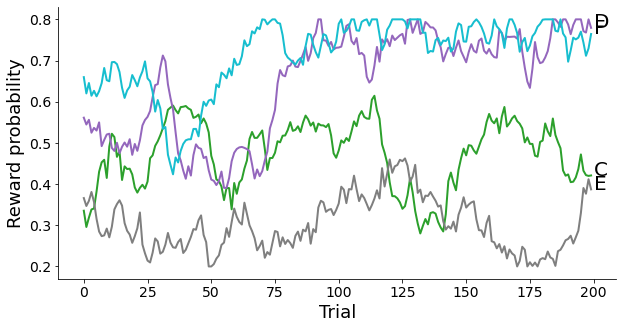

In [3]:
# plot fig 1 two step task random walk

from imports import*
from utils import *

a,b,c,d = create_rndwlk(4,200)
plt.figure(figsize=(10,5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(a,color=sns.color_palette("tab10" )[2],lw=2)
plt.text(x=200,y=a[199],s='C',size=20)

plt.plot(b,color=sns.color_palette("tab10" )[4],lw=2)
plt.text(x=200,y=b[199],s='D',size=20)

plt.plot(c,color=sns.color_palette("tab10" )[7],lw=2)
plt.text(x=200,y=c[199],s='E',size=20)

plt.plot(d,color=sns.color_palette("tab10" )[9],lw=2)
plt.text(x=200,y=d[199],s='F',size=20)

plt.tick_params(which='major', labelsize=14)

plt.xlabel('Trial',size=18)
plt.ylabel('Reward probability',size=18)

# plt.savefig('../plots/fig_1b',dpi=300,bbox_inches='tight')

plt.show()

In [3]:
# true noise calculations
m = ['hybrid','habit','kdh']

df_mean = df.groupby('agent').mean()
df_mean['model'] = np.repeat(['hybrid','habit','kdh'],100)

dfp = []
for model in m:
    cur = pd.read_csv(f'../results/{model}/{model}_parameters.csv')
    cur.drop(columns=['Unnamed: 0'],inplace=True)
    dfp.append(cur)
    
noise_hybrid=(dfp[0]['beta_1']-dfp[0]['beta_1'].min())/(dfp[0]['beta_1'].max()-dfp[0]['beta_1'].min())
noise_habit=(dfp[1]['beta_1']-dfp[1]['beta_1'].min())/(dfp[1]['beta_1'].max()-dfp[1]['beta_1'].min())

a=np.absolute(dfp[2]['p_0']-.5)
noise_kdh = (a-a.min())/(a.max()-a.min())

df_noise = pd.DataFrame({
                        'noise_hybrid':noise_hybrid,
                        'noise_habit':noise_habit,
                        'noise_kdh':noise_kdh}
                        )

df_mean['noise'] = ((df_noise.values).T).flatten()

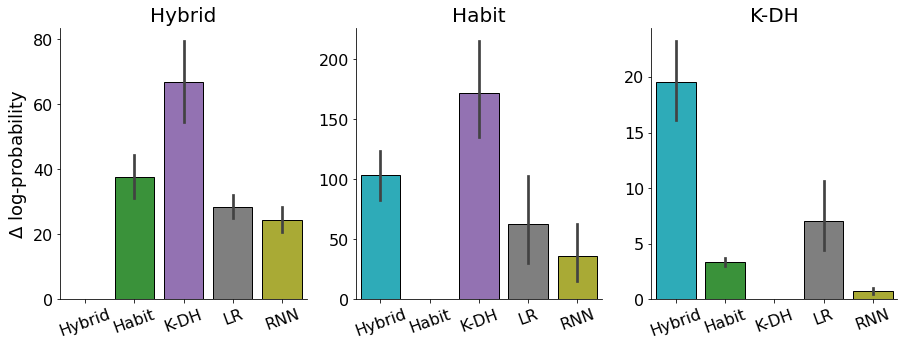

In [4]:
# plot fig 2_a

models = ['hybrid','habit','kdh']
names = ['Hybrid','Habit','K-DH']


pla = [
    
    sns.color_palette("tab10")[9], sns.color_palette("tab10" )[2], sns.color_palette("tab10" )[4],
    sns.color_palette("tab10")[7], sns.color_palette("tab10" )[8]
]

xx = []
for m in models:
    data = df_mean[df_mean.model==m]
    data = data.filter(regex='test_nll')
    x = []
    for col in data.columns:
        x.append(-(data[f'test_nll_{m}'] - data[col]).values)
    xx.append(x)
    
fig, axes = plt.subplots(1,3,figsize=(15,5))
for i,m in enumerate(names):
    sns.barplot(data=pd.DataFrame(np.array(xx[i]).T),ax=axes[i],palette=pla,edgecolor='k')
    axes[i].set_title(m,size=20)
    axes[i].set_xticklabels(labels=['Hybrid','Habit','K-DH','LR','RNN'])
    axes[i].tick_params(axis='x', which='major', labelsize=16, rotation=20)
    axes[i].tick_params(axis='y', which='major', labelsize=16)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    
#     axes[i].grid(axis='y',alpha=.5)

axes[0].set_ylabel('$\it{Δ}$ log-probability',size=18)
plt.savefig('../plots/fig_2a',dpi=300,bbox_inches='tight')
plt.show()

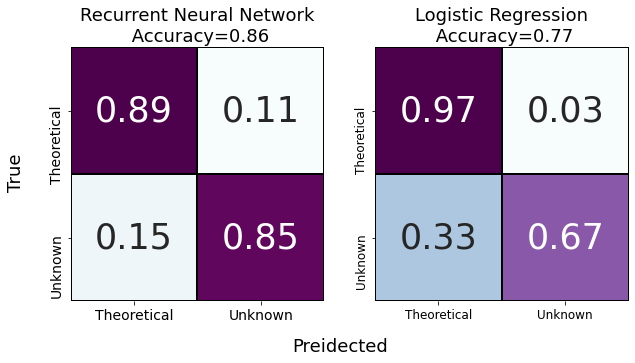

In [6]:
# plot fig 2_b
from sklearn.metrics import confusion_matrix , accuracy_score

df_mean['type'] = np.repeat([0,1,2],100)
classification_by = ['test_nll_rnn',
                     'test_nll_lr'] 
all_j = []
all_acc = [ ]
for i in classification_by:
    for j,m in enumerate(models):        
        y_true = (df_mean['type'].values != j ).astype(int)
        y_pred = (np.array(df_mean[f'test_nll_{m}'] - df_mean[i]) > 0).astype(int)
        all_j.append(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'))
        acc = accuracy_score(y_true=y_true,y_pred=y_pred)
        all_acc.append(acc)
        

a,b = np.array(all_acc).reshape(2,3).mean(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(ax=axes[0],data=(np.array(all_j)[:3].sum(axis=0)/3),
            linewidth=2,
            cmap='BuPu',
            linecolor='k',
            annot=True,
            square=True,
            cbar=False,
            annot_kws={"size":35}
           )
           
axes[0].set_xticklabels(['Theoretical','Unknown'],rotation=0,size=14)
axes[0].set_yticklabels(['Theoretical','Unknown'],rotation=90,size=14)
axes[0].set_title(f'Recurrent Neural Network\n Accuracy=%.2f'%a,size=18)

sns.heatmap(ax=axes[1],data=(np.array(all_j)[3:].sum(axis=0)/3),
            linewidth=2,
            cmap='BuPu',
            linecolor='k',
            annot=True,
            square=True,
            cbar=False,
            fmt='.2f',
            annot_kws={"size":35}
           )

axes[1].set_xticklabels(['Theoretical','Unknown'],rotation=0,size=12)
axes[1].set_yticklabels(['Theoretical','Unknown'],rotation=90,size=12)
axes[1].set_title(f'Logistic Regression\n Accuracy=%.2f'%b,size=18)

plt.text(x=-2.9,y=1.1,s='True',size=18,rotation=90)
plt.text(x=-.65,y=2.4,s='Preidected',size=18)
# plt.savefig('../plots/fig_2b',dpi=300,bbox_inches='tight')
plt.show()

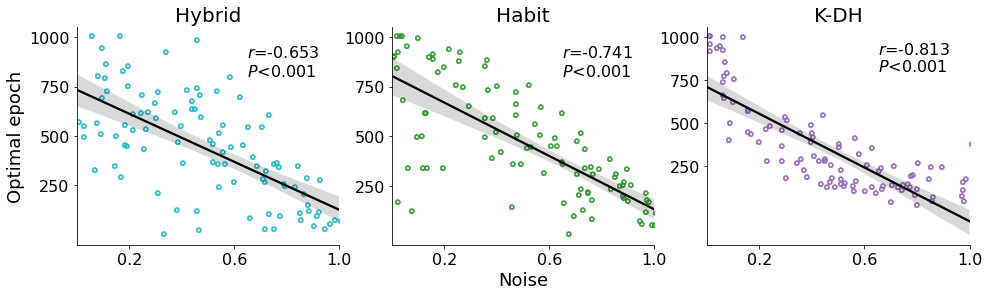

In [7]:
# plot fig 3_a
fig, axes = plt.subplots(1,3,figsize=(16,4))

for i,m in enumerate(models):
    
    data = df_mean[df_mean.model==m]
    
    sns.scatterplot(ax=axes[i],
                    x=1-data['noise'],
                    y=data['optimal_epoch'], 
                    marker="$\circ$", ec="face", s=60 , color=pla[i])

    sns.regplot(ax=axes[i],
                x=1-data['noise'],
                y=data['optimal_epoch'],
                scatter=False,color='k',truncate=True)  


    axes[i].set_title(names[i],size=20)
    
    axes[i].set_xticks(ticks=[.2,.6,1])
    axes[i].tick_params(axis='x', which='major', labelsize=16)
    axes[i].set_xlabel('',size=20)
    
    axes[i].set_yticks(ticks=[250,500,750,1000])
    axes[i].tick_params(axis='y', which='major', labelsize=16)
    axes[i].set_ylabel('',size=20)
    
    r,p = stats.pearsonr(x=1-data['noise'],y=data['optimal_epoch'])
    axes[i].text(x=.65,y=900, s='${r}$=%.3f'%r,size=16)     # {\u03C1}
    axes[i].text(x=.65,y=800, s='$\it{P}$<0.001',size=16)
    
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[1].set_xlabel('Noise',size=18)
    
#     axes[i].grid(alpha=.2)



axes[0].set_ylabel('Optimal epoch',size=18)

# plt.savefig('../plots/fig_3a',dpi=400,bbox_inches='tight')
plt.show()

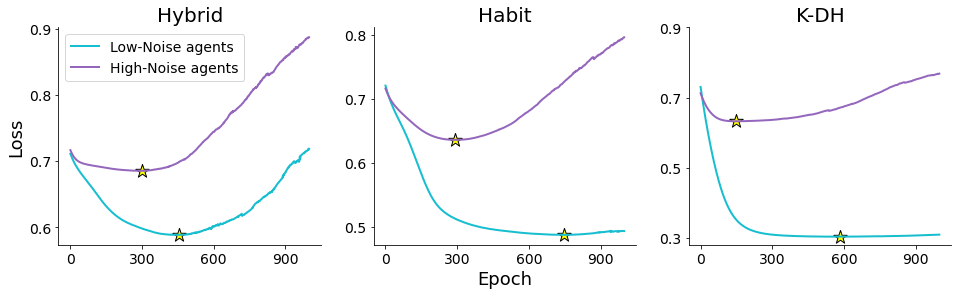

In [30]:
# plot fig 3_b
x = np.array(loss_val).reshape(300,3,1000)

loss_hybrid = x.mean(axis=1)[:100]
loss_habit = x.mean(axis=1)[100:200]
loss_kdh = x.mean(axis=1)[200:]

all_loss = [loss_hybrid,loss_habit,loss_kdh]

all_tick = [[.6,.7,.8,.9],[.5,.6,.7,.8],[.3,.5,.7,.9]]

noise_hybrid=(df_mean[df_mean.model=='hybrid']['noise']>0.535).values
noise_habit=(df_mean[df_mean.model=='habit']['noise']>0.48).values
noise_kdh=(df_mean[df_mean.model=='kdh']['noise']>0.54).values

all_noise = [noise_hybrid,noise_habit,noise_kdh]
fig, axes = plt.subplots(1,3,figsize=(16,4))

for i in range(3):
    
    loss = all_loss[i]
    a = all_noise[i]

    axes[i].plot(loss[a].mean(axis=0), color=sns.color_palette("tab10", 10)[9], label='Low-Noise agents',linewidth=2)
    axes[i].plot(loss[~a].mean(axis=0), color=sns.color_palette("tab10", 10)[4], label='High-Noise agents',linewidth=2)

#     axes[i].axhline(y=-np.log(.5),color='k',ls='--',label='Baseline random')
    axes[i].scatter(x=np.argmin(loss[a].mean(axis=0)),y=loss[a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
    axes[i].scatter(x=np.argmin(loss[~a].mean(axis=0)),y=loss[~a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
    
    axes[i].tick_params(axis='x', which='major', labelsize=14)
    axes[i].tick_params(axis='y', which='major', labelsize=14)
    axes[i].set_title(names[i],size=20)

    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    
    axes[i].set_xticks(ticks=[0,300,600,900])
    axes[i].set_yticks(ticks=all_tick[i])
    
#     axes[i].grid(alpha=.3)

axes[0].legend(fontsize=14)
axes[1].set_xlabel('Epoch',size=18)
axes[0].set_ylabel('Loss',size=18)

plt.savefig('../plots/fig_3b',dpi=300,bbox_inches='tight')

plt.show()

Model haybrid
low M=260.38
low SD=170.54159492628185
high M=551.22
high SD=241.62551934760535
Ttest_indResult(statistic=6.88381591669806, pvalue=2.7886333601372977e-10)
Model habit
low M=255.24
low SD=152.6729262181085
high M=615.6
high SD=329.5887133989876
Ttest_indResult(statistic=6.944645700979805, pvalue=2.090240948044282e-10)
Model kdh
low M=146.98
low SD=112.06596093372866
high M=529.28
high SD=300.32575913497664
Ttest_indResult(statistic=8.348380758867027, pvalue=2.277567893948868e-13)


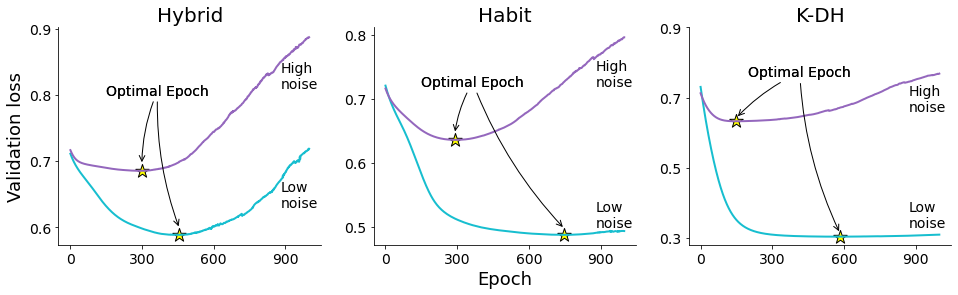

In [28]:
# plot fig 3_b_alt
x = np.array(loss_val).reshape(300,3,1000)

loss_hybrid = x.mean(axis=1)[:100]
loss_habit = x.mean(axis=1)[100:200]
loss_kdh = x.mean(axis=1)[200:]

all_loss = [loss_hybrid,loss_habit,loss_kdh]

all_tick = [[.6,.7,.8,.9],[.5,.6,.7,.8],[.3,.5,.7,.9]]

noise_hybrid=(df_mean[df_mean.model=='hybrid']['noise']>0.535).values
noise_habit=(df_mean[df_mean.model=='habit']['noise']>0.48).values
noise_kdh=(df_mean[df_mean.model=='kdh']['noise']>0.54).values

all_noise = [noise_hybrid,noise_habit,noise_kdh]
fig, axes = plt.subplots(1,3,figsize=(16,4))

for i in range(3):
    
    loss = all_loss[i]
    a = all_noise[i]

    axes[i].plot(loss[a].mean(axis=0), color=sns.color_palette("tab10", 10)[9], label='Low-Noise agents',linewidth=2)
    axes[i].plot(loss[~a].mean(axis=0), color=sns.color_palette("tab10", 10)[4], label='High-Noise agents',linewidth=2)

#     axes[i].axhline(y=-np.log(.5),color='k',ls='--',label='Baseline random')
    axes[i].scatter(x=np.argmin(loss[a].mean(axis=0)),y=loss[a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
    axes[i].scatter(x=np.argmin(loss[~a].mean(axis=0)),y=loss[~a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
    
    axes[i].tick_params(axis='x', which='major', labelsize=14)
    axes[i].tick_params(axis='y', which='major', labelsize=14)
    axes[i].set_title(names[i],size=20)

    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    
    axes[i].set_xticks(ticks=[0,300,600,900])
    axes[i].set_yticks(ticks=all_tick[i])
    
    
#     axes[i].grid(alpha=.3)

# axes[0].legend(fontsize=14)
axes[1].set_xlabel('Epoch',size=18)
axes[0].set_ylabel('Validation loss',size=18)


loss = all_loss[0]
a = all_noise[0]

print('Model haybrid')
print(f'low M={np.argmin(loss[~a],axis=1).mean()}')
print(f'low SD={np.argmin(loss[~a],axis=1).std()}')

print(f'high M={np.argmin(loss[a],axis=1).mean()}')
print(f'high SD={np.argmin(loss[a],axis=1).std()}')

print(stats.ttest_ind(a=np.argmin(loss[a],axis=1),b=np.argmin(loss[~a],axis=1),alternative='greater'))

axes[0].annotate("Optimal Epoch",
            xy=(np.argmin(loss[a].mean(axis=0)), loss[a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(150, .80), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[0].annotate("Optimal Epoch",
            xy=(np.argmin(loss[~a].mean(axis=0)), loss[~a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(150, .80), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )


axes[0].text(x=880,y=.81, s='High\nnoise',size=14)
axes[0].text(x=880,y=.63, s='Low\nnoise',size=14)


loss = all_loss[1]
a = all_noise[1]

print('Model habit')
print(f'low M={np.argmin(loss[~a],axis=1).mean()}')
print(f'low SD={np.argmin(loss[~a],axis=1).std()}')

print(f'high M={np.argmin(loss[a],axis=1).mean()}')
print(f'high SD={np.argmin(loss[a],axis=1).std()}')
print(stats.ttest_ind(a=np.argmin(loss[a],axis=1),b=np.argmin(loss[~a],axis=1),alternative='greater'))

axes[1].annotate("Optimal Epoch",
            xy=(np.argmin(loss[a].mean(axis=0)), loss[a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(150, .72), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[1].annotate("Optimal Epoch",
            xy=(np.argmin(loss[~a].mean(axis=0)), loss[~a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(150, .72), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[1].text(x=880,y=.72, s='High\nnoise',size=14)
axes[1].text(x=880,y=.5, s='Low\nnoise',size=14)


loss = all_loss[2]
a = all_noise[2]

print('Model kdh')
print(f'low M={np.argmin(loss[~a],axis=1).mean()}')
print(f'low SD={np.argmin(loss[~a],axis=1).std()}')

print(f'high M={np.argmin(loss[a],axis=1).mean()}')
print(f'high SD={np.argmin(loss[a],axis=1).std()}')
print(stats.ttest_ind(a=np.argmin(loss[a],axis=1),b=np.argmin(loss[~a],axis=1),alternative='greater'))

axes[2].annotate("Optimal Epoch",
            xy=(np.argmin(loss[a].mean(axis=0)), loss[a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(200, .76), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[2].annotate("Optimal Epoch",
            xy=(np.argmin(loss[~a].mean(axis=0)), loss[~a].mean(axis=0).min()+.01),     
            xycoords='data',size=14,
            xytext=(200, .76), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[2].text(x=870,y=.66, s='High\nnoise',size=14)
axes[2].text(x=870,y=.33, s='Low\nnoise',size=14)

plt.savefig('../plots/fig_3b_alt',dpi=300,bbox_inches='tight')

plt.show()